In [1]:
import os
import cv2
import numpy as np
import joblib
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog

In [2]:
DATA_DIR_TRAIN = 'data/train'
DATA_DIR_TEST = 'data/test'
DATA_DIR_VAL = 'data/val'

TARGET_CLASS = 'car'
NEG_CLASS = 'background'
MODEL_DIR = 'models/'

# Creating HOG

In [3]:
# based on the standard configuration established by the original Dalal & Triggs paper (2005) for human detection.
HOG_PARAMS = {
    'orientations': 12,
    'pixels_per_cell': (4, 4), # divides image into a grid of squares, calculate the gradient for every pixel and pools them into a single histogram
    'cells_per_block': (2, 2), # performs normalization to handle lighting changes
    'block_norm': 'L2-Hys', # normalizes the histogram: {'L1', 'L1-sqrt', 'L2', 'L2-Hys'}, optional
    'visualize': False,
    'transform_sqrt': True # applies the square root to each pixel intensity before processing
}
PATCH_SIZE = (64, 32)

In [4]:
def load_and_extract_features(data_dir):
    X = [] # Feature vectors
    y = [] # Labels
    
    print("Loading data and computing HOG features...")
    
    # Objects
    path = os.path.join(data_dir, TARGET_CLASS)
    
    print(f"Processing class: {TARGET_CLASS}")
    for img_file in os.listdir(path):
        img_path = os.path.join(path, img_file)
        img = cv2.imread(img_path)
        if img is None: continue
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
        gray = cv2.resize(gray, PATCH_SIZE) 
        
        features = hog(gray, **HOG_PARAMS)
        X.append(features)
        y.append(TARGET_CLASS)

    # Background
    print(f"Processing class: {NEG_CLASS}")
    path = os.path.join(data_dir, NEG_CLASS)
    if os.path.exists(path):
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)
            img = cv2.imread(img_path)
            if img is None: continue
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, PATCH_SIZE)
            
            features = hog(gray, **HOG_PARAMS)
            X.append(features)
            y.append('background')

    return np.array(X), np.array(y)

In [5]:
X_train, y_train = load_and_extract_features(DATA_DIR_TRAIN)

Loading data and computing HOG features...
Processing class: car
Processing class: background


In [6]:
X_val, y_val = load_and_extract_features(DATA_DIR_VAL)

Loading data and computing HOG features...
Processing class: car
Processing class: background


In [7]:
X = np.vstack((X_train, X_val))
y = np.hstack((y_train, y_val))

print(f"Feature Matrix Shape: {X.shape}")

Feature Matrix Shape: (88515, 5040)


In [ ]:
np.savez_compressed('hog_features_64_32.npz', X=X, y=y)

# data = np.load('hog_features_64_32.npz')
# X = data['X']
# y = data['y']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training SVM

## Standard Scaler

In [29]:
# model with scaler
from sklearn.preprocessing import StandardScaler

# 1. Initialize scaler
scaler = StandardScaler()

# 2. Fit and transform your training data
X_train_scaled = scaler.fit_transform(X_train)

# 3. Save the scaler! (CRITICAL: You must use the SAME scaler during detection)
joblib.dump(scaler, 'scaler.pkl')

# 4. Train SVM on scaled data
model = LinearSVC(random_state=42, max_iter=2000, class_weight='balanced', C=0.1)
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"C={0.1} & StandardScaler => Accuracy: {acc:.4f}")
print()
print(classification_report(y_test, preds))

model_name = f'hog_svm_model_car_0.1_stdscaler.pkl'
joblib.dump(model, os.path.join(MODEL_DIR, model_name))
print(f"Model saved to {MODEL_DIR}{model_name}")

C=0.1 & StandardScaler => Accuracy: 0.9017

              precision    recall  f1-score   support

  background       0.71      0.86      0.78      3561
         car       0.96      0.91      0.94     14142

    accuracy                           0.90     17703
   macro avg       0.84      0.89      0.86     17703
weighted avg       0.91      0.90      0.91     17703

Model saved to models/hog_svm_model_car_0.1_stdscaler.pkl


## Simple SVM with different C

In [ ]:
print("Training SVM...")

C=[0.1, 1, 10]

for c in C:
    model = LinearSVC(random_state=42, max_iter=2000, class_weight='balanced', C=c)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"C={c} => Accuracy: {acc:.4f}")
    print()
    print(classification_report(y_test, preds))


    model_name = f'hog_svm_model_car_{c}.pkl'
    joblib.dump(model, os.path.join(MODEL_DIR, model_name))
    print(f"Model saved to {MODEL_DIR}{model_name}")
    print("-" * 50)

Training SVM...
C=0.1 => Accuracy: 0.9017

              precision    recall  f1-score   support

  background       0.71      0.86      0.78      3561
         car       0.96      0.91      0.94     14142

    accuracy                           0.90     17703
   macro avg       0.84      0.89      0.86     17703
weighted avg       0.91      0.90      0.91     17703

Model saved to models/hog_svm_model_car_0.1.pkl
--------------------------------------------------
C=1 => Accuracy: 0.8947

              precision    recall  f1-score   support

  background       0.70      0.85      0.76      3561
         car       0.96      0.91      0.93     14142

    accuracy                           0.89     17703
   macro avg       0.83      0.88      0.85     17703
weighted avg       0.91      0.89      0.90     17703

Model saved to models/hog_svm_model_car_1.pkl
--------------------------------------------------
C=10 => Accuracy: 0.8896

              precision    recall  f1-score   support

 

In [ ]:
# model chosen based on the accuracy score and classification report
model_name = 'hog_svm_model_car_0.1.pkl'
MODEL_PATH = os.path.join(MODEL_DIR, model_name)

## Model with more bg samples

In [35]:
X_train, y_train = load_and_extract_features(DATA_DIR_TRAIN)
X_val, y_val = load_and_extract_features(DATA_DIR_VAL)

X = np.vstack((X_train, X_val))
y = np.hstack((y_train, y_val))

print(f"Feature Matrix Shape: {X.shape}")

Loading data and computing HOG features...
Processing class: car
Processing class: background
Loading data and computing HOG features...
Processing class: car
Processing class: background
Feature Matrix Shape: (115515, 5040)


In [36]:
np.savez_compressed('hog_features_more_bg.npz', X=X, y=y)

In [37]:
model = LinearSVC(random_state=42, max_iter=2000, class_weight='balanced', C=0.1)
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Accuracy: {acc:.4f}")
print()
print(classification_report(y_test, preds))

model_name = f'hog_svm_model_car_0.1_more_bg.pkl'
joblib.dump(model, os.path.join(MODEL_DIR, model_name))
print(f"Model saved to {MODEL_DIR}{model_name}")


Accuracy: 0.9022

              precision    recall  f1-score   support

  background       0.73      0.81      0.77      3561
         car       0.95      0.93      0.94     14142

    accuracy                           0.90     17703
   macro avg       0.84      0.87      0.85     17703
weighted avg       0.91      0.90      0.90     17703

Model saved to models/hog_svm_model_car_0.1_more_bg.pkl


# Evaluation

In [14]:
import pandas as pd
import cv2
import joblib
import numpy as np
import time
import os
from skimage.feature import hog
from collections import defaultdict

In [13]:
TEST_CSV = '../data/labels/test_labels.csv'
IMG_DIR = "../data/bdd100k_images_100k/100k/train"
NUM_TEST_IMAGES = 15  # Limit to 10 images for debugging (Increase to 100 or 1000 later)
IOU_THRESHOLDS = np.arange(0.5, 0.96, 0.05) # 0.5, 0.55, ..., 0.95
# IOU_THRESHOLDS = [0.1, 0.3, 0.5]

# HOG Parameters (MUST MATCH TRAINING)
WIN_SIZE = PATCH_SIZE

STEP_SIZE = 8
SCALE_FACTOR = 1.25

In [40]:
def get_iou(boxA, boxB):
    '''
    Measure how much two boxes overlap.
    '''
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA) # if boxes do not overlap, xB - xA or yB - yA will be negative -> 0 area
    # individual box areas
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # Inclusion-Exclusion Principle
    unionArea = float(boxAArea + boxBArea - interArea)
    if unionArea == 0: return 0 # avoid division by zero
    return interArea / unionArea

def non_max_suppression(boxes, probs, overlapThresh=0.3):
    ''' 
    Filter overlapping bounding boxes.
    The sliding window will detect the same car several times (slightly shifted each time).
    We need to keep only the best one.
    '''
    if len(boxes) == 0: return [], []

    boxes = boxes.astype("float")
    pick = []
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs) # sort by confidence scores

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute overlap ratio (IoU) - between the current box and every other box still in the list
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(
            idxs, 
            np.concatenate(
                ([last], np.where(overlap > overlapThresh)[0]) # remove indices with high overlap
            )
        )
        
    return boxes[pick].astype("int"), probs[pick]

def detect_objects(model, img, score_threshold, nms_threshold):
    # Sliding Window Logic
    detections = []
    confidences = []
    
    current_scale = 0
    scale_img = img.copy()
    
    # SVM was trained on 64x64 patches. If a car in the image is 300x300, it won't fit in the window.
    # We start with the full image. We scan it. Then we shrink the image (divide size by SCALE_FACTOR) and scan it again.
    # keep shrinking until the image is smaller than our 64x64 window.
    while scale_img.shape[0] >= WIN_SIZE[1] and scale_img.shape[1] >= WIN_SIZE[0]:
        for y in range(0, scale_img.shape[0] - WIN_SIZE[1], STEP_SIZE):
            for x in range(0, scale_img.shape[1] - WIN_SIZE[0], STEP_SIZE):
                window = scale_img[y:y+WIN_SIZE[1], x:x+WIN_SIZE[0]] # crop window
                gray = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
                feats = hog(gray, **HOG_PARAMS).reshape(1, -1)
                
                score = model.decision_function(feats)[0] # positive = car, negative = background

                if score > score_threshold:                    
                    scale_multiplier = (SCALE_FACTOR ** current_scale)
                    final_x = int(x * scale_multiplier)
                    final_y = int(y * scale_multiplier)
                    final_x2 = int((x+WIN_SIZE[0]) * scale_multiplier)
                    final_y2 = int((y+WIN_SIZE[1]) * scale_multiplier)
                    detections.append([final_x, final_y, final_x2, final_y2])

                    confidences.append(score)
        
        new_w = int(scale_img.shape[1] / SCALE_FACTOR)
        new_h = int(scale_img.shape[0] / SCALE_FACTOR)
        scale_img = cv2.resize(scale_img, (new_w, new_h))
        current_scale += 1

    # Apply NMS
    if len(detections) > 0:
        return non_max_suppression(np.array(detections), np.array(confidences), overlapThresh=nms_threshold)
    return [], []

def calculate_ap(rec, prec):
    # Compute Average Precision (Area under PR Curve)
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    i = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

# mAP

In [117]:
def main():
    print("Loading Model & Data...")
    model = joblib.load(MODEL_PATH)
    df = pd.read_csv(TEST_CSV)
    
    unique_images = df['image'].unique()[:NUM_TEST_IMAGES] 
    all_preds = []   
    all_gts = []     
    latencies = []

    print(f"Starting inference on {len(unique_images)} images...")
    for i, img_name in enumerate(unique_images):
        full_img_name = img_name if img_name.endswith('.jpg') else img_name + '.jpg'
        img_path = os.path.join(IMG_DIR, full_img_name)
        
        img = cv2.imread(img_path)
        if img is None: continue

        # Measure Latency
        start = time.time()
        # Returns lists: Boxes, Scores
        boxes, scores = detect_objects(model, img) 
        end = time.time()
        latencies.append(end - start)

        # Store Predictions
        for box, score in zip(boxes, scores):
            all_preds.append({
                'image': img_name,
                'class': TARGET_CLASS,
                'score': score,
                'bbox': box
            })
            
        # Store Ground Truths
        gts = df[df['image'] == img_name]
        for _, row in gts.iterrows():
            if row['category'] == TARGET_CLASS:
                all_gts.append({
                    'image': img_name,
                    'class': row['category'],
                    'bbox': [row['x1'], row['y1'], row['x2'], row['y2']]
                })
        
        print(f"Processed {i+1}/{len(unique_images)} - {img_name} - found {len(boxes)} objects")

    avg_latency = np.mean(latencies)
    print(f"\nAverage Latency: {avg_latency:.4f} seconds/image")

    # CALCULATE mAP
    print("\nCalculating metrics...")
    mean_aps = []

    aps_per_threshold = []

    if len(all_gts) == 0:
        print("  No Ground Truths for this class in this subset.")

    # Sort Predictions by Confidence Score (High to Low)
    class_preds = sorted(all_preds, key=lambda x: x['score'], reverse=True)
    
    for iou_thresh in IOU_THRESHOLDS:
        tp = np.zeros(len(class_preds))
        fp = np.zeros(len(class_preds))
        
        # Keep track of which GT box has already been matched to avoid double counting
        # key: image_name, value: list of matched GT indices
        matched_gt_indices = defaultdict(set)
        
        for p_idx, pred in enumerate(class_preds):
            img_id = pred['image']
            bb_pred = pred['bbox']
            
            # Get GTs for this specific image
            # We store original index 'g_idx' to track uniqueness
            img_gts_with_idx = [(i, g) for i, g in enumerate(all_gts) if g['image'] == img_id]
            
            best_iou = 0
            best_gt_idx = -1
            
            # Find the single best GT match for this prediction
            for (g_idx, gt) in img_gts_with_idx:
                # Logic: If this GT is already matched, we cannot use it again for this threshold
                if g_idx in matched_gt_indices[img_id]:
                    continue 
                    
                iou = get_iou(bb_pred, gt['bbox'])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = g_idx
            
            # Threshold Check
            if best_iou >= iou_thresh:
                tp[p_idx] = 1
                matched_gt_indices[img_id].add(best_gt_idx) # Lock this GT
            else:
                fp[p_idx] = 1
        
        # Compute AP
        fp_cumsum = np.cumsum(fp)
        tp_cumsum = np.cumsum(tp)
        rec = tp_cumsum / len(all_gts)
        prec = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        
        ap = calculate_ap(rec, prec)
        aps_per_threshold.append(ap)
    
    class_map = np.mean(aps_per_threshold)
    mean_aps.append(class_map)
    print(f"  mAP@0.5:0.95: {class_map:.4f}")

    print(f"\n=== FINAL RESULTS ===")
    print(f"Total mAP: {np.mean(mean_aps):.4f}")
    print(f"Latency: {avg_latency:.4f}s")
    
if __name__ == "__main__":
    main()

Loading Model & Data...
Starting inference on 15 images...
Processed 1/15 - 000d35d3-41990aa4 - found 55 objects
Processed 2/15 - 005ee183-bcfab89f - found 60 objects
Processed 3/15 - 0062298d-fd69d0ec - found 28 objects
Processed 4/15 - 006a4209-4f3bf6cf - found 74 objects
Processed 5/15 - 008d2a0a-ac995caf - found 21 objects
Processed 6/15 - 0090c713-2854b392 - found 58 objects
Processed 7/15 - 0092e44c-3b3dee4b - found 50 objects
Processed 8/15 - 00c497ae-595d361b - found 31 objects
Processed 9/15 - 00e11419-e4eeba84 - found 21 objects
Processed 10/15 - 00f7eac8-5193d600 - found 62 objects
Processed 11/15 - 00ffeef4-b105ce4d - found 72 objects
Processed 12/15 - 010a3063-d255402b - found 46 objects
Processed 13/15 - 01fa77d0-e86c6400 - found 15 objects
Processed 14/15 - 0204aad7-8ad8ba92 - found 65 objects
Processed 15/15 - 025022b5-e92fb84b - found 30 objects

Average Latency: 409.2814 seconds/image

Calculating metrics...
  mAP@0.5:0.95: 0.0000

=== FINAL RESULTS ===
Total mAP: 0.0

# Test Thresholds

In [30]:
import matplotlib.pyplot as plt

def test_model_with_images(model, test_images, test_thresholds, detect_objects=detect_objects):
            
        for img_name in test_images:
            img_path = os.path.join(IMG_DIR, img_name)
            original_img = cv2.imread(img_path)

            fig, axes = plt.subplots(
                1, len(test_thresholds),
                figsize=(5 * len(test_thresholds), 5)
            )

            for ax, t in zip(axes, test_thresholds):
                img_copy = original_img.copy()
                boxes, scores = detect_objects(model, img_copy, score_threshold=t)

                for box, s in zip(boxes, scores):
                    cv2.rectangle(
                        img_copy,
                        (box[0], box[1]),
                        (box[2], box[3]),
                        (0, 255, 0),
                        2
                    )
                    cv2.putText(
                        img_copy,
                        f"{s:.2f}",
                        (box[0], box[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 255, 0),
                        1
                    )

                ax.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
                ax.set_title(f"threshold = {t}")
                ax.axis("off")

            fig.suptitle(img_path, fontsize=16)
            plt.tight_layout()
            plt.show()

## Testing the model with c=0.1

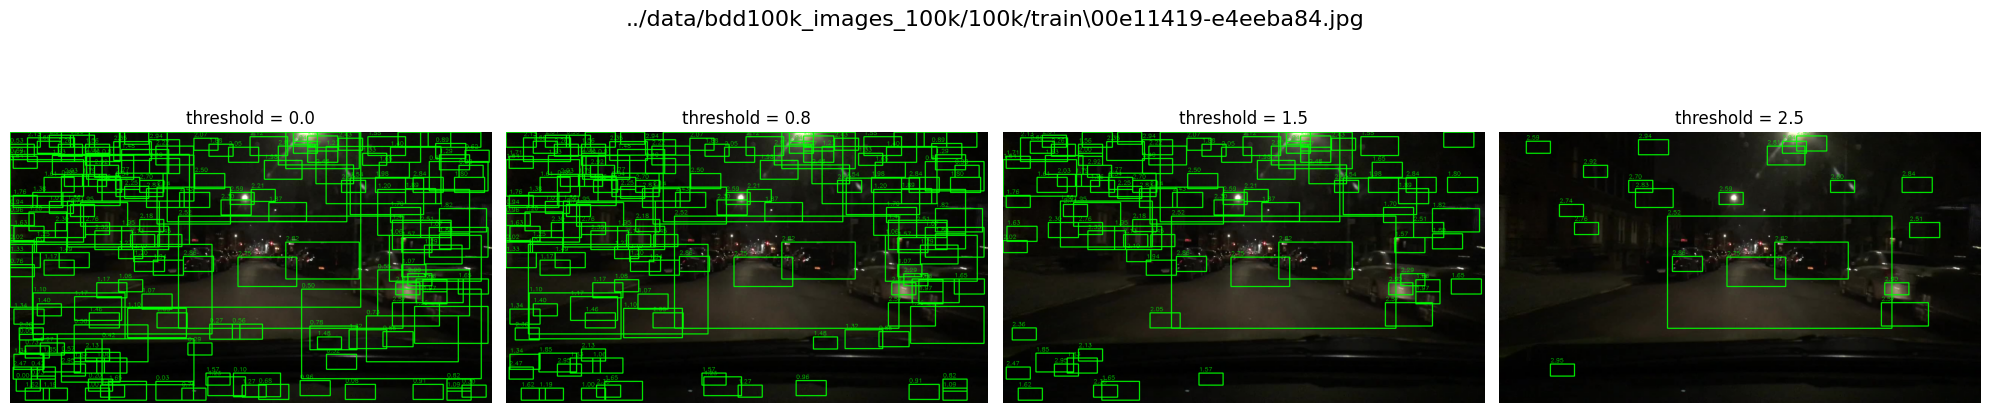

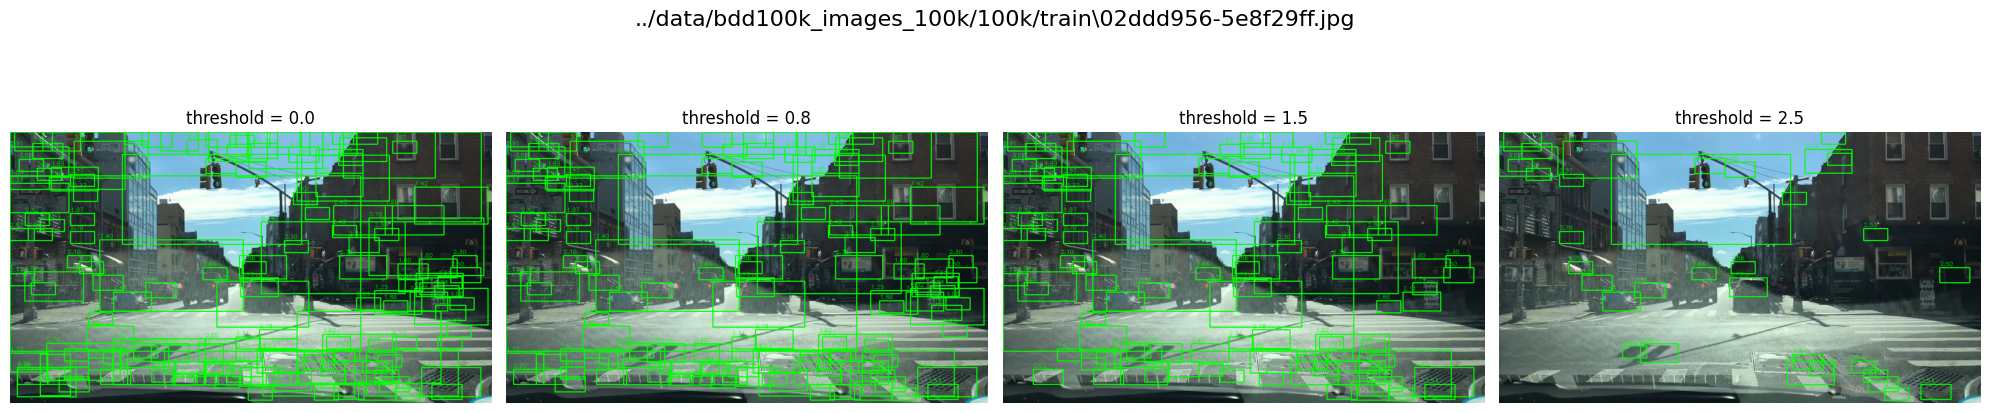

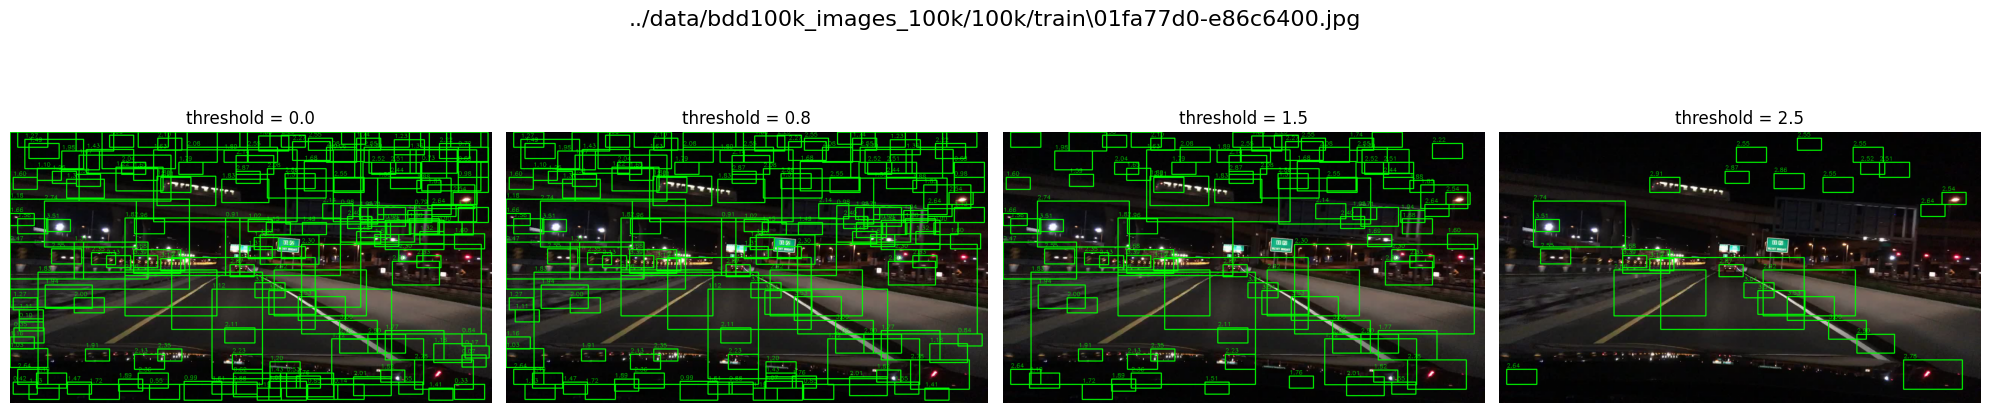

In [ ]:
model = joblib.load(MODEL_PATH)

# test_images = ['0204aad7-8ad8ba92.jpg'] 
test_images = ['00e11419-e4eeba84.jpg', '02ddd956-5e8f29ff.jpg', '01fa77d0-e86c6400.jpg']
test_thresholds = [0.0, 0.8, 1.5, 2.5]
test_model_with_images(model, test_images, test_thresholds)

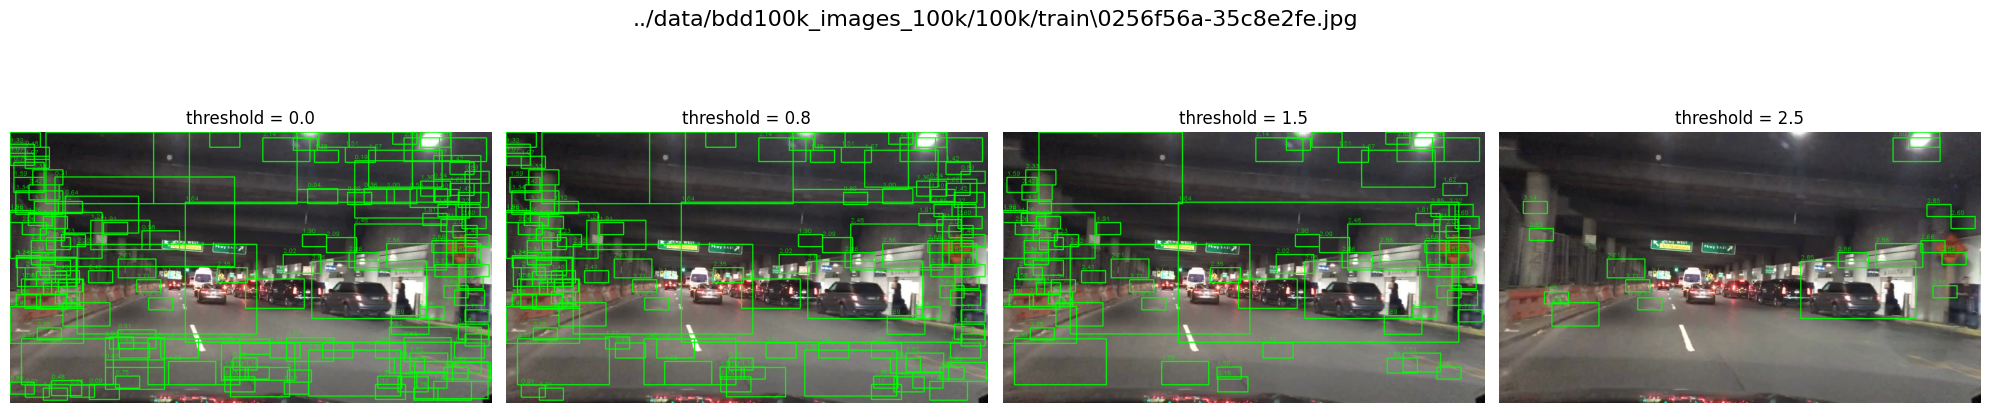

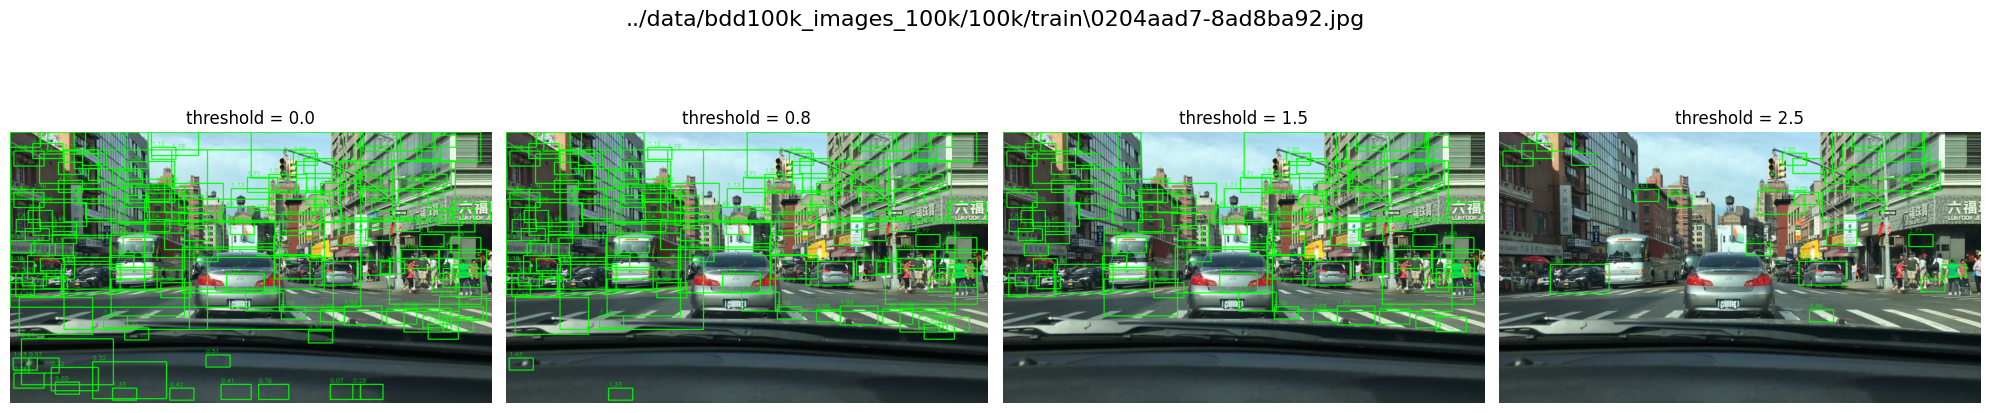

In [26]:
test_images = ['0256f56a-35c8e2fe.jpg', '0204aad7-8ad8ba92.jpg'] 
test_thresholds = [0.0, 0.8, 1.5, 2.5]
test_model_with_images(model, test_images, test_thresholds)

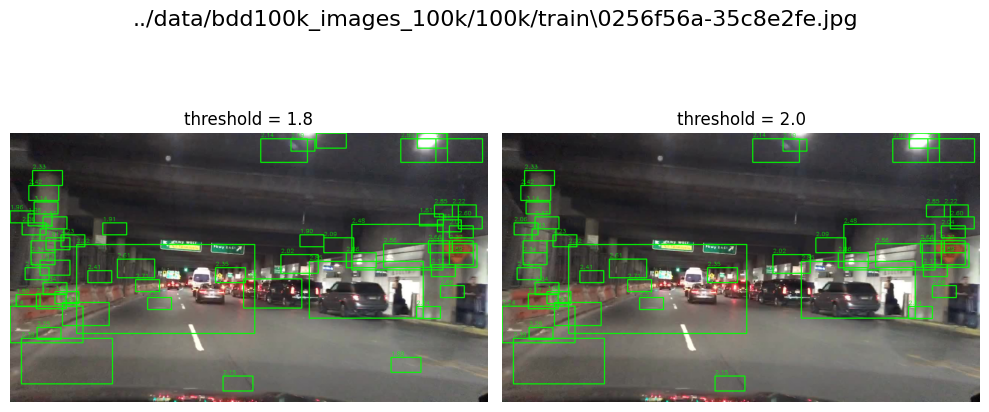

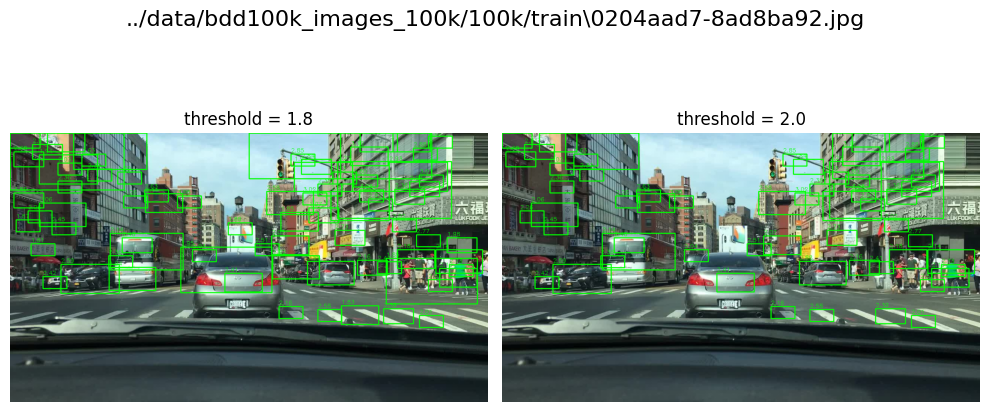

In [27]:
test_images = ['0256f56a-35c8e2fe.jpg', '0204aad7-8ad8ba92.jpg'] 
test_thresholds = [1.8, 2.0]
test_model_with_images(model, test_images, test_thresholds)

## Testing the model with Scaler

In [ ]:
def detect_objects_scaler(model, img, score_threshold):
    detections = []
    confidences = []
    
    current_scale = 0
    scale_img = img.copy()
    
    while scale_img.shape[0] >= WIN_SIZE[1] and scale_img.shape[1] >= WIN_SIZE[0]:
        for y in range(0, scale_img.shape[0] - WIN_SIZE[1], STEP_SIZE):
            for x in range(0, scale_img.shape[1] - WIN_SIZE[0], STEP_SIZE):
                window = scale_img[y:y+WIN_SIZE[1], x:x+WIN_SIZE[0]]
                gray = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
                feats = hog(gray, **HOG_PARAMS).reshape(1, -1)
                
                feats_scaled = scaler.transform(feats) # Use the loaded scaler

                score = model.decision_function(feats_scaled)[0]

                if score > score_threshold:                    
                    scale_multiplier = (SCALE_FACTOR ** current_scale)
                    final_x = int(x * scale_multiplier)
                    final_y = int(y * scale_multiplier)
                    final_x2 = int((x+WIN_SIZE[0]) * scale_multiplier)
                    final_y2 = int((y+WIN_SIZE[1]) * scale_multiplier)
                    detections.append([final_x, final_y, final_x2, final_y2])

                    confidences.append(score)
        
        new_w = int(scale_img.shape[1] / SCALE_FACTOR)
        new_h = int(scale_img.shape[0] / SCALE_FACTOR)
        scale_img = cv2.resize(scale_img, (new_w, new_h))
        current_scale += 1

    # Apply NMS
    if len(detections) > 0:
        return non_max_suppression(np.array(detections), np.array(confidences))
    return [], []

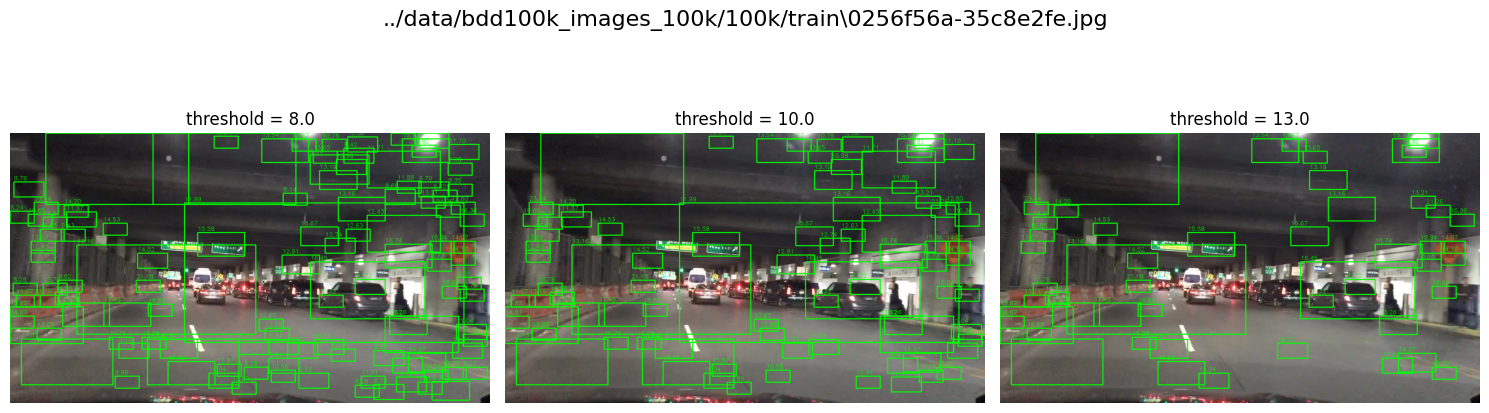

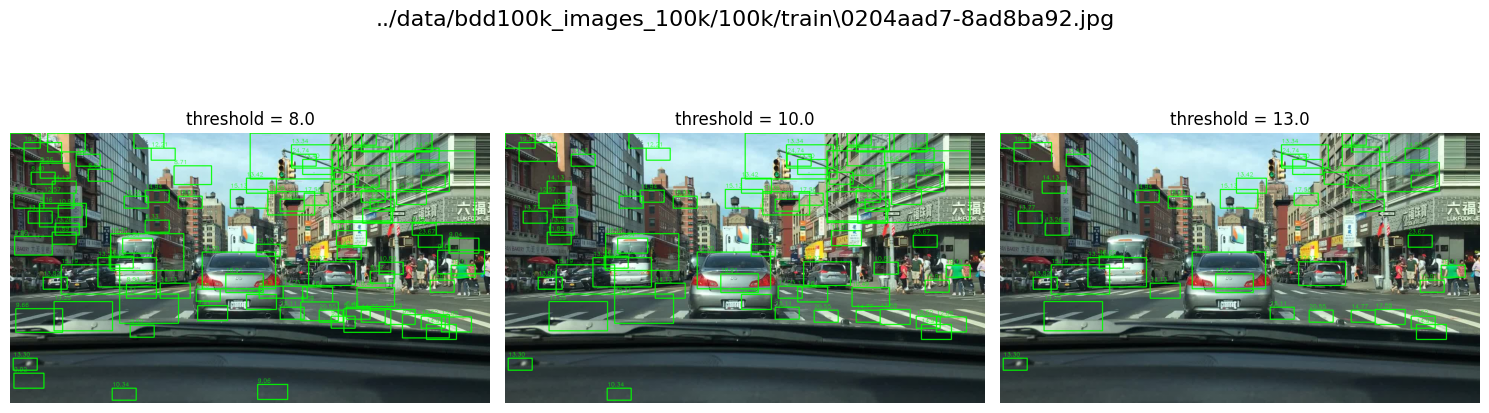

In [33]:
model_name = 'hog_svm_model_car_0.1_stdscaler.pkl'
MODEL_PATH = os.path.join(MODEL_DIR, model_name)
model = joblib.load(MODEL_PATH)

test_images = ['0256f56a-35c8e2fe.jpg', '0204aad7-8ad8ba92.jpg'] 
test_thresholds = [8.0, 10.0, 13.0]
test_model_with_images(model, test_images, test_thresholds, detect_objects=detect_objects_scaler)

## More background samples

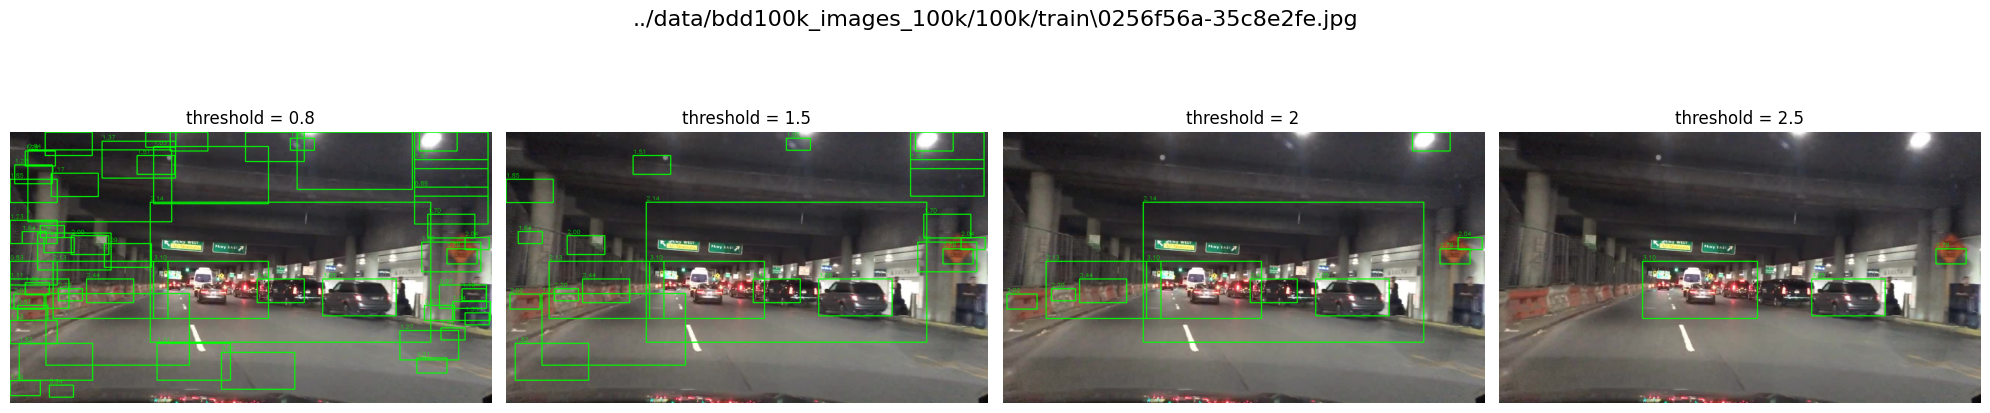

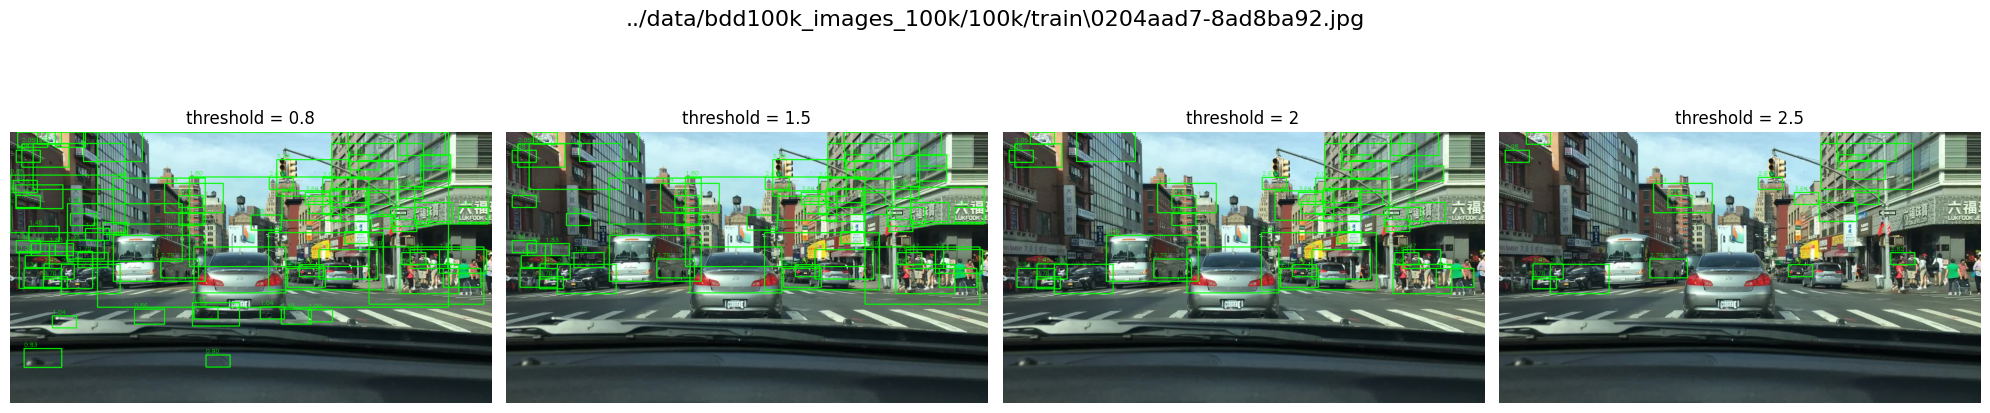

In [ ]:
model_name = 'hog_svm_model_car_0.1_more_bg.pkl'
MODEL_PATH = os.path.join(MODEL_DIR, model_name)
model = joblib.load(MODEL_PATH)

test_images = ['0256f56a-35c8e2fe.jpg', '0204aad7-8ad8ba92.jpg'] 
test_thresholds = [0.8, 1.5, 2, 2.5]
test_model_with_images(model, test_images, test_thresholds)

# Test other params

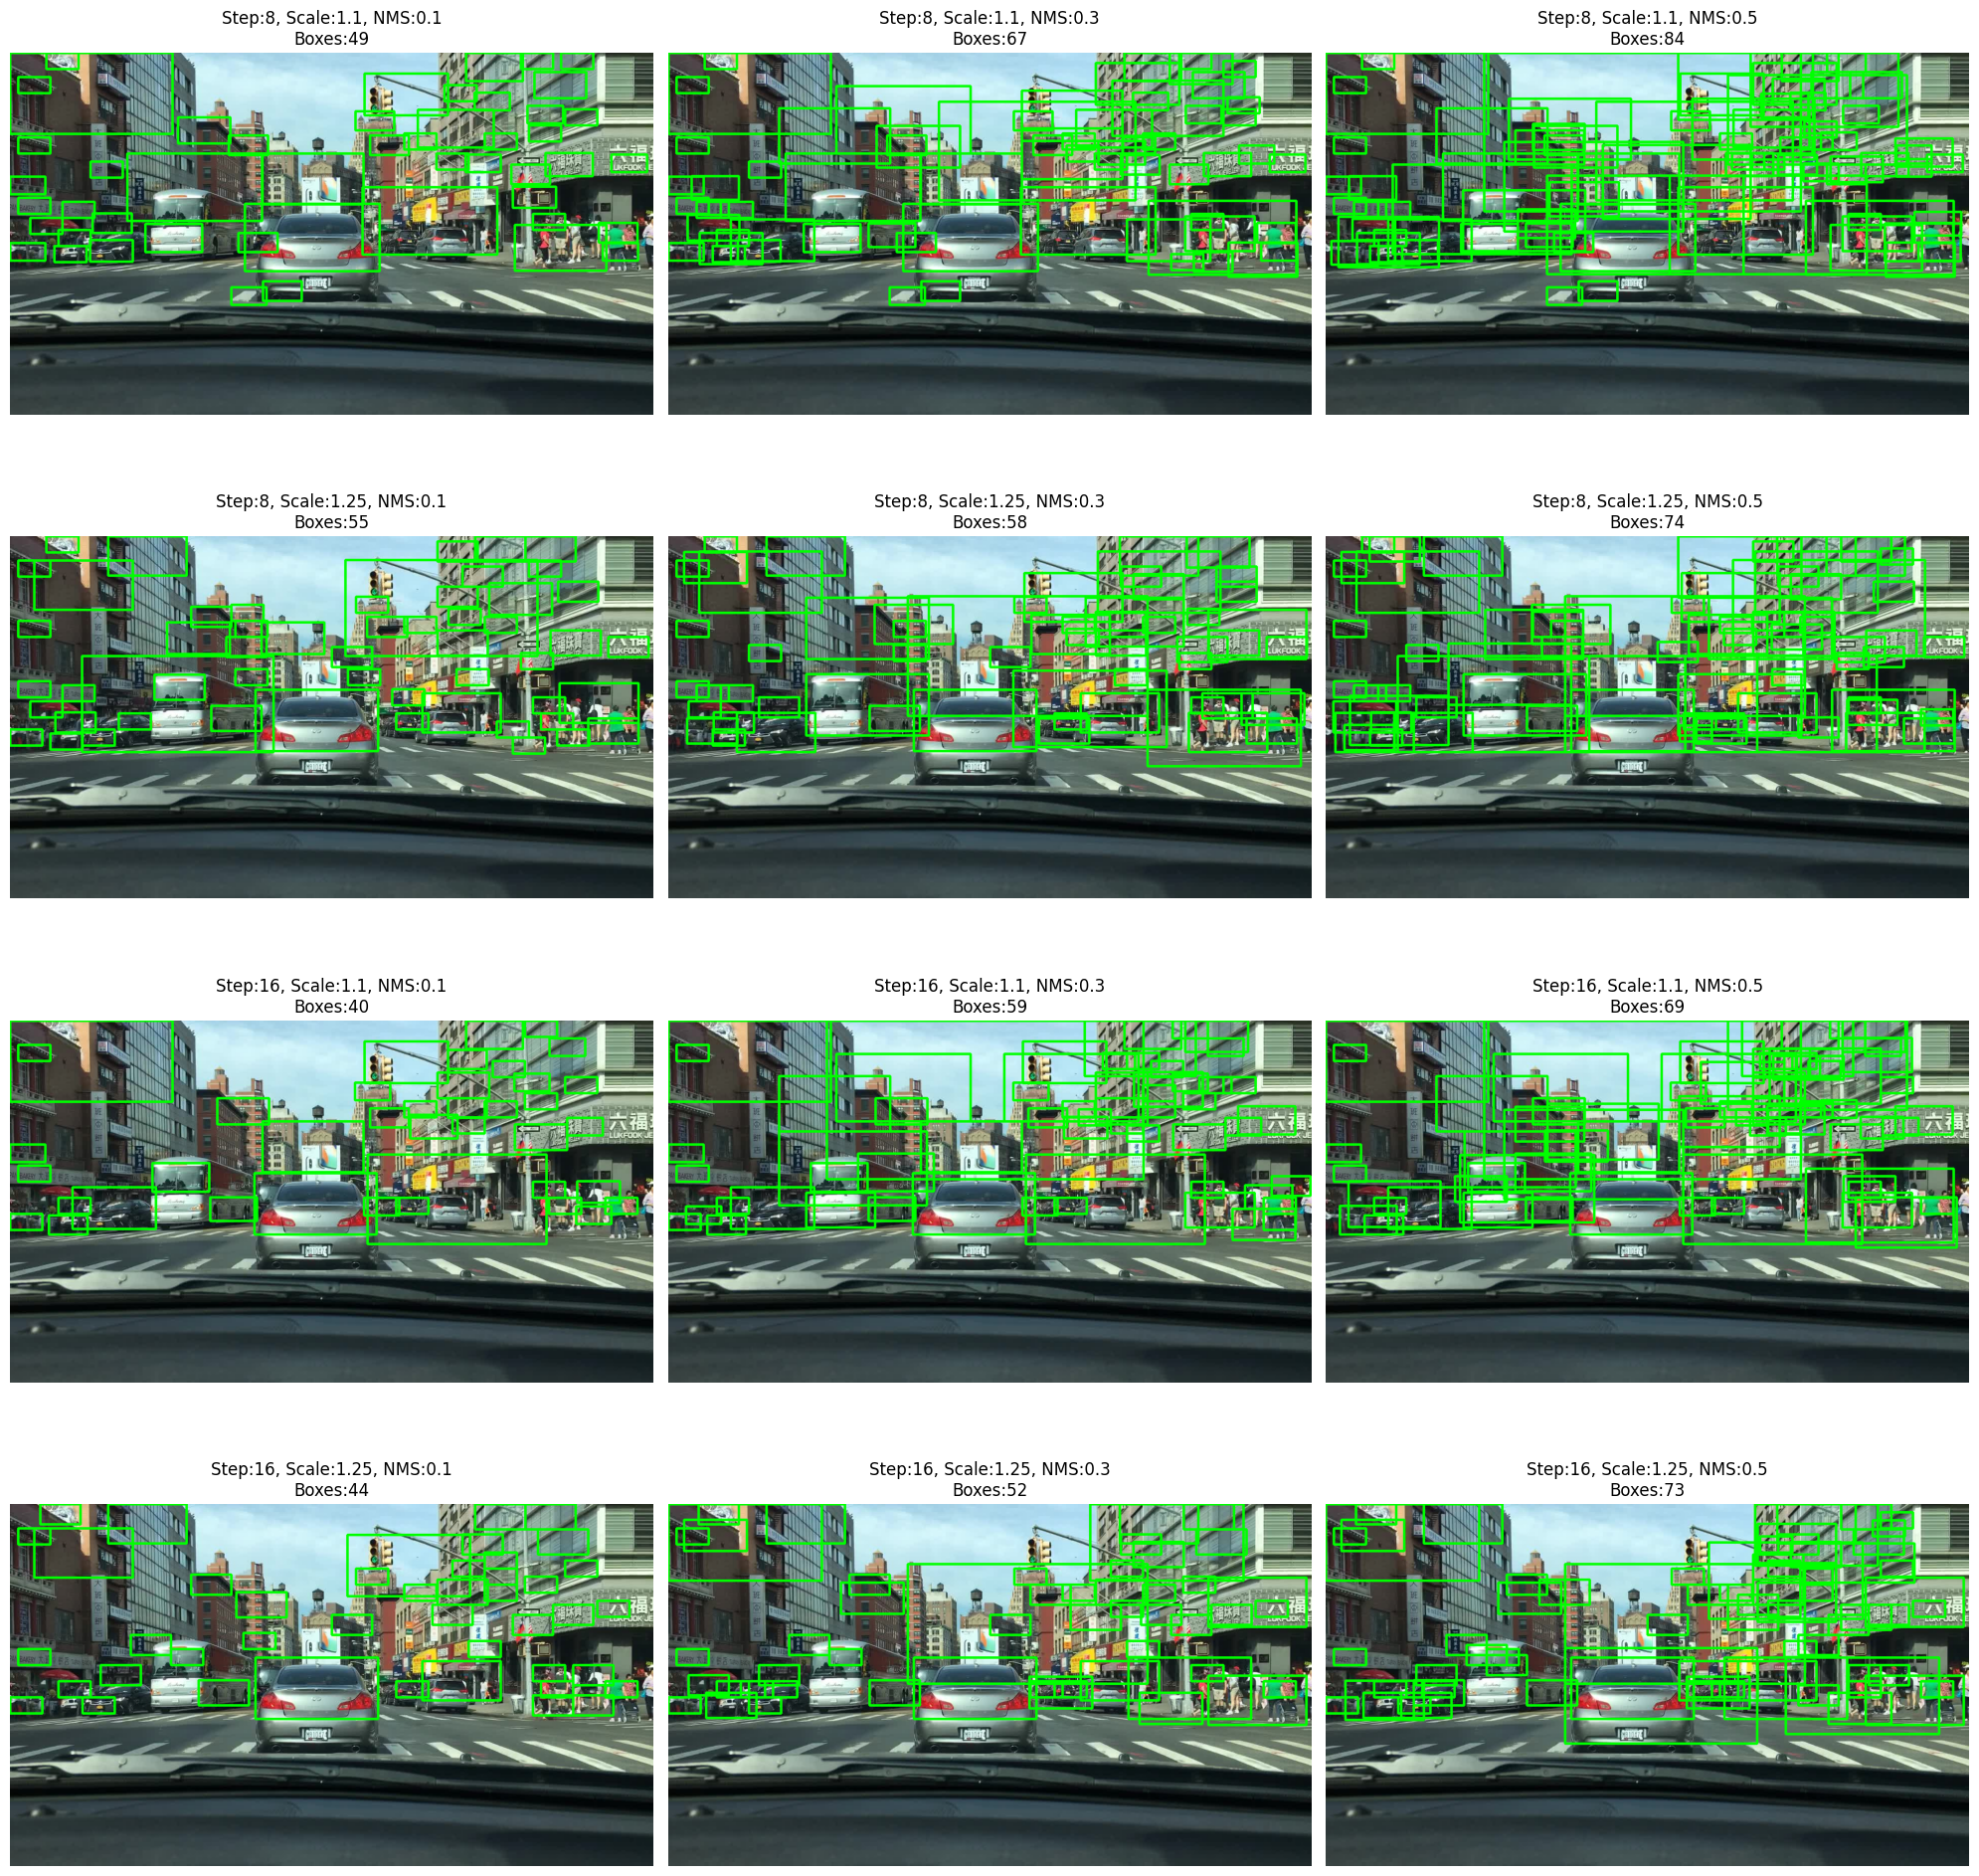

In [43]:
model_name = 'hog_svm_model_car_0.1_more_bg.pkl'
MODEL_PATH = os.path.join(MODEL_DIR, model_name)
model = joblib.load(MODEL_PATH)

test_steps = [8, 16]         # Small vs Large jumps
test_scales = [1.1, 1.25]    # Fine vs Coarse pyramid
test_nms = [0.1, 0.3, 0.5]        # Aggressive vs Loose merging

img_name = "0204aad7-8ad8ba92" 
img_path = os.path.join(IMG_DIR, img_name + '.jpg')
img_orig = cv2.imread(img_path)

# fig, axes = plt.subplots(len(test_steps), len(test_scales) * len(test_nms), figsize=(24, 12))

# for i, step in enumerate(test_steps):
#     column_idx = 0
#     for j, scale in enumerate(test_scales):
#         for k, nms in enumerate(test_nms):
#             STEP_SIZE = step
#             SCALE_FACTOR = scale
            
#             img_draw = img_orig.copy()
#             # Pass NMS directly to the function
#             boxes, scores = detect_objects(model, img_draw, score_threshold=1.5, nms_threshold=nms)
            
#             for box in boxes:
#                 cv2.rectangle(img_draw, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 3)
                
#             ax = axes[i, column_idx]
#             ax.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
#             ax.set_title(f"St:{step} Sc:{scale} NMS:{nms}\nBoxes:{len(boxes)}", fontsize=10)
#             ax.axis('off')
#             column_idx += 1

# plt.tight_layout()
# plt.show()

import itertools

combinations = list(itertools.product(test_steps, test_scales, test_nms))

# Calculate grid size (e.g., 4 columns)
cols = 3
rows = (len(combinations) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten() # Make it a 1D list so we can use a single index

for idx, (step, scale, nms) in enumerate(combinations):
    STEP_SIZE = step
    SCALE_FACTOR = scale
    
    img_draw = img_orig.copy()
    boxes, scores = detect_objects(model, img_draw, score_threshold=1.5, nms_threshold=nms)
    
    for box in boxes:
        cv2.rectangle(img_draw, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 3)
            
    axes[idx].imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f"Step:{step}, Scale:{scale}, NMS:{nms}\nBoxes:{len(boxes)}")
    axes[idx].axis('off')

# Hide unused subplots
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Prev

Debug: Visualizing 0204aad7-8ad8ba92
Found 40 boxes.


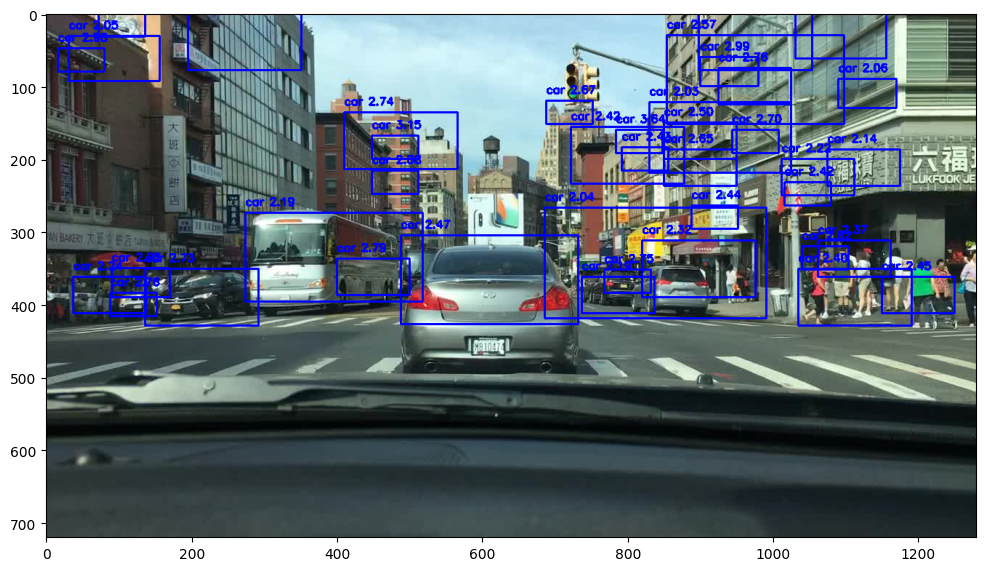

In [39]:
# Quick Debug Visualization
import cv2
import matplotlib.pyplot as plt

model_name = 'hog_svm_model_car_0.1_more_bg.pkl'
MODEL_PATH = os.path.join(MODEL_DIR, model_name)
model = joblib.load(MODEL_PATH)

# Load one test image
img_name = "0204aad7-8ad8ba92"
img_path = os.path.join(IMG_DIR, img_name if img_name.endswith('.jpg') else img_name+'.jpg')
img = cv2.imread(img_path)

# Run detection with a LOWER threshold
# We manually override the threshold inside detect_objects or just print raw scores
print(f"Debug: Visualizing {img_name}")
boxes, scores = detect_objects(model, img, [2.0])

print(f"Found {len(boxes)} boxes.")
# print(f"Top 5 Scores: {scores[:5]}") 

for box, score in zip(boxes, scores):
    x1, y1, x2, y2 = box
    # Draw Blue Box
    # print(f"car, {x1}, {y1}, {x2}, {y2}")
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(img, f"car {score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Grid Search

In [ ]:
# Parameters to test
candidate_step_sizes = [8, 16]
candidate_scale_factors = [1.1, 1.25, 1.5]
candidate_nms_thresholds = [0.2, 0.3, 0.5]
candidate_score_thresholds = [0.7, 1.2, 1.5]

In [ ]:
import itertools
import pandas as pd

def parameter_sweep(model, df_test):
    results = []
    
    # Generate all possible combinations of parameters
    combinations = list(itertools.product(
        candidate_step_sizes, 
        candidate_scale_factors, 
        candidate_nms_thresholds,
        candidate_score_thresholds
    ))

    print(f"Starting sweep of {len(combinations)} combinations...")

    for step, scale, nms_t, score_t in combinations:
        print(f"\nTesting: Step={step}, Scale={scale}, NMS={nms_t}, Score={score_t}")
        
        # 1. Update Global Parameters (or pass them to detect_objects)
        global STEP_SIZE, SCALE_FACTOR, IOU_THRESHOLDS
        STEP_SIZE = step
        SCALE_FACTOR = scale
        
        # 2. Run Inference on a subset (e.g., 20-50 images)
        all_preds = []
        all_gts = []
        # ... [Insert your existing inference loop here] ...
        # Ensure you use nms_t and score_t inside detect_objects logic
        
        # 3. Calculate mAP
        # ... [Insert your existing mAP calculation logic here] ...
        final_map = np.mean(mean_aps)
        
        # 4. Log Result
        results.append({
            'step_size': step,
            'scale_factor': scale,
            'nms_threshold': nms_t,
            'score_threshold': score_t,
            'mAP': final_map,
            'latency': avg_latency
        })

    # Save to CSV for easy comparison
    sweep_df = pd.DataFrame(results)
    sweep_df.to_csv('parameter_sweep_results.csv', index=False)
    print("\nSweep Complete! Results saved to 'parameter_sweep_results.csv'")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
df = pd.read_csv('parameter_sweep_results.csv')

# Plot Latency vs mAP
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='latency', y='mAP', hue='step_size', style='scale_factor')
plt.title("Trade-off: Accuracy (mAP) vs. Speed (Latency)")
plt.show()